In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 얼굴 감정 탐지(facial expression detection): MTCNN과 DeepFace 활용

## 1) 얼굴 탐지: MTCNN(Multi-task Cascaded Convolutional Networks) 활용
- 바운딩박스: 정규화되지 않은 실제 값으로 [x, y, w, h] 제공
- confidence: 대상을 얼굴로 확신하는 확률. 0에서 1사이.
- keypoints: left_eye, right_eye, nose, mouth_left, mouth_right의 좌표
- 정면 얼굴이 아니거나 매우 작은 경우에는 탐지하지 못하는 한계 감안 필요

In [ ]:
! pip install opencv-python
! pip install mtcnn

In [ ]:
# MTCNN (Multi-task Cascaded Convolutional Networks) 라이브러리에서 MTCNN 클래스를 임포트
# 얼굴 검출을 수행하는데 사용됨
from mtcnn import MTCNN

# OpenCV 라이브러리를 임포트
# 이미지 및 동영상 처리에 널리 사용되며, 얼굴 인식, 객체 검출 등의 기능 제공
import cv2

# matplotlib의 pyplot 모듈을 임포트
# 이미지, 그래프, 데이터 시각화를 수행하는 데 사용됨
from matplotlib import pyplot as plt

# pandas 라이브러리를 임포트
# 데이터 분석 및 테이블 형식 데이터 처리에 사용됨 (CSV, Excel, DataFrame 등)
import pandas as pd

# os 모듈을 임포트
# 운영체제(OS) 관련 기능을 사용하며, 파일 및 디렉토리 경로 조작 가능
import os

# json 모듈을 임포트
# JSON 형식의 데이터를 읽고 쓰는 기능 제공 (딕셔너리 변환, 파일 저장 등)
import json


In [ ]:
# MTCNN face detector 초기화
detector = MTCNN()

# 분석할 이미지 로드와 전처리
image_path = '/content/drive/MyDrive/파이썬특강/문과코딩_021725/faces.jpg'  # Update this path
image = cv2.imread(image_path)
image_height, image_width, image_channels = image.shape
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces: 이미지 내 복수의 얼굴도 리스트로 모두 분석
faces = detector.detect_faces(image_rgb)

In [ ]:
# bounding box와 detected face 그리기

for i, face in enumerate(faces):
    x, y, width, height = face['box']
    cv2.rectangle(image_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)
    cv2.putText(image_rgb,str(i), (x, y-10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (255, 0, 0), 1)   # 0.5=폰크 크기, 2=굵기

# 출력과 저장
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
#plt.savefig(os.path.join(image_path.split('.jpg')[0]+'_face'+'.jpg', bbox_inches='tight', pad_inches=0) # 같은 폴더에 이미지명_face.jpg로 변환돼 저장
plt.show()

In [ ]:
# 분석 결과 저장: 필요한 것만 DataFrame 활용

results=[]
for i, face in enumerate(faces):
    face['face_id']=i
    face['image_size']=[image_width, image_height]
    results.append({k: face[k] for k in ['face_id','box','confidence','image_size']  if k in face})

results_df=pd.DataFrame(results)
print(results_df)

## 2) 얼굴과 감정 함께 탐지: MTCNN과 DeepFace 연계 활용
- region: 얼굴 위치 정보 제공. [x, y, w, h] 방식.
- emotion: 7개 감정(angry, disgust, fear, happy, sad, surprise, neutral) 확률
- face_confidence: 대상이 얼굴임을 확신하는 정도


- Smart Eye의 Affectiva: 심층 감정 탐지를 제공하지만 유료로 SDK access 필요

*MTCNN 탐지 결과

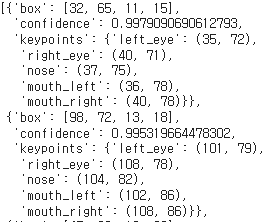

*DeepFace로 하나의 얼굴 탐지 결과: age, gender, race, emotion 4가지 출력

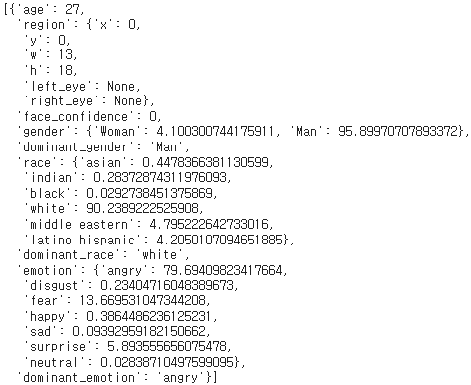




In [ ]:
! pip install opencv-python
! pip install mtcnn
! pip install deepface

In [ ]:
# MTCNN (Multi-task Cascaded Convolutional Networks) 라이브러리에서 MTCNN 클래스를 임포트
# 얼굴 검출(Face Detection)을 수행하는데 사용됨
from mtcnn import MTCNN

# OpenCV 라이브러리를 임포트
# 이미지 및 비디오 처리 기능을 제공하며, 얼굴 인식, 필터 적용, 객체 검출 등에 사용됨
import cv2

# matplotlib의 pyplot 모듈을 임포트
# 이미지, 그래프, 데이터 시각화를 수행하는 데 사용됨
from matplotlib import pyplot as plt

# DeepFace 라이브러리에서 DeepFace 모듈을 임포트
# 얼굴 인식(Face Recognition), 감정 분석(Emotion Detection), 나이/성별 예측 등에 사용됨
from deepface import DeepFace


In [ ]:
# MTCNN face detector 초기화
detector = MTCNN()

# 분석할 이미지 로드와 전처리
image_path = '/content/drive/MyDrive/파이썬특강/문과코딩_021725/faces.jpg'
image = cv2.imread(image_path)
image_height, image_width, image_channels = image.shape
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #  BGR 색상 공간에서 RGB 색상 공간으로 변환. 실재와 유사한 색감.

# Detect faces: 이미지 내 복수의 얼굴도 리스트로 모두 분석
faces = detector.detect_faces(image_rgb)

In [ ]:
# 얼굴 바운딩박스별 감정 분석

result_analysis=[]
for i, face in enumerate(faces):
    x, y, width, height = face['box']
    face_img = image_rgb[y:y+height, x:x+width]  # image_rgb에서 face 영역 추출
    try:
        analysis = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)  # actions=['age', 'gender', 'race', 'emotion']에서 'emotion'만 선택
        analysis[0]['face_id']=i         # face id 추가
        result_analysis.append(analysis[0])
        emotion = analysis[0]['dominant_emotion']
        cv2.rectangle(image_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)  # (0, 255, 0): 사각형 선의 색 = 녹색. 선 두께 = 2
        cv2.putText(image_rgb, str(i)+'_'+emotion, (x, y-10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (255, 0, 0), 1)  # (x, y-10) = 텍스트 시작 위치, 0.5=폰크 크기, 2=굵기
    except Exception as e:
        print("Error in emotion analysis:", e)

# 출력과 저장
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
#plt.savefig(os.path.join(image_path.split('.jpg')[0]+'_face'+'.jpg', bbox_inches='tight', pad_inches=0) # 같은 폴더에 이미지명_face.jpg로 변환돼 저장
plt.show()

In [ ]:
# 분석 결과 저장
import pandas as pd

results_all=[]
for face, result in zip(faces, result_analysis):
    result.update(face)
    result['image_size']=[image_width, image_height]
    results_all.append({k: result[k] for k in ['face_id','box','confidence','emotion','dominant_emotion','image_size']  if k in result})

results_all_df=pd.DataFrame(results_all)
results_all_df